
Dataset shape: (1944, 78)

Train Accuracy:      0.68
Validation Accuracy: 0.65
Test Accuracy:       0.65
Validation Accuracy: 0.65
Test Accuracy: 0.65
Final Test Accuracy (after using validation data): 0.57


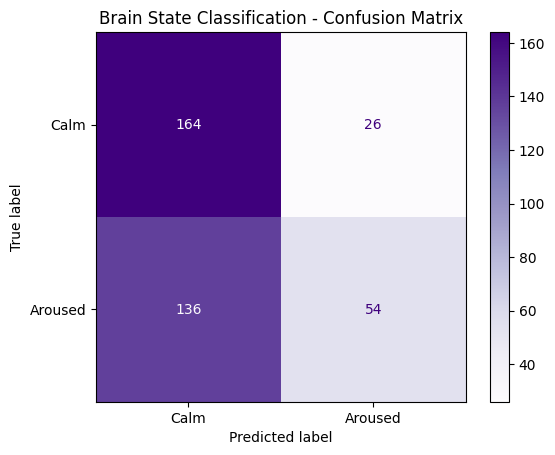

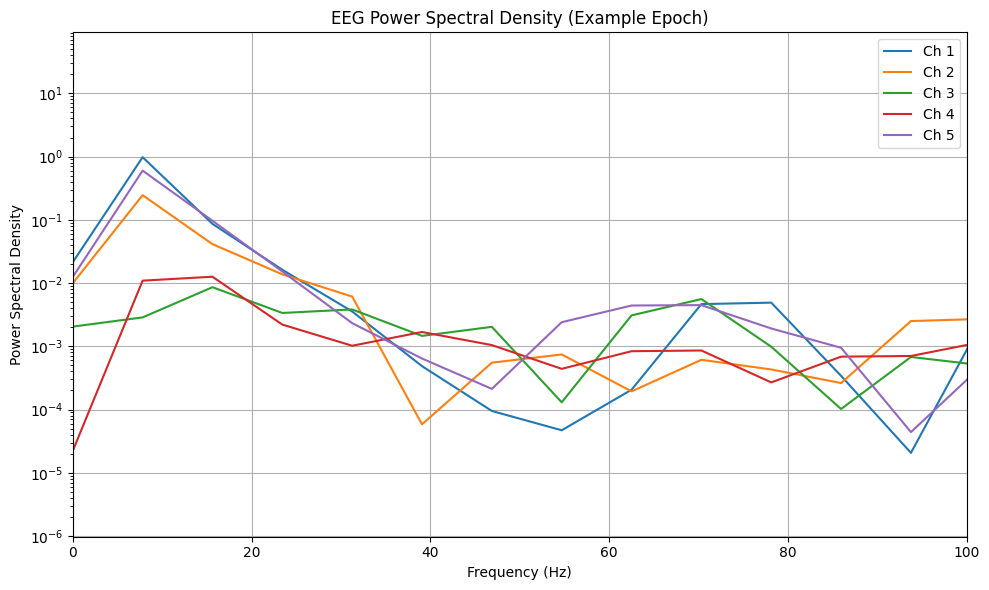

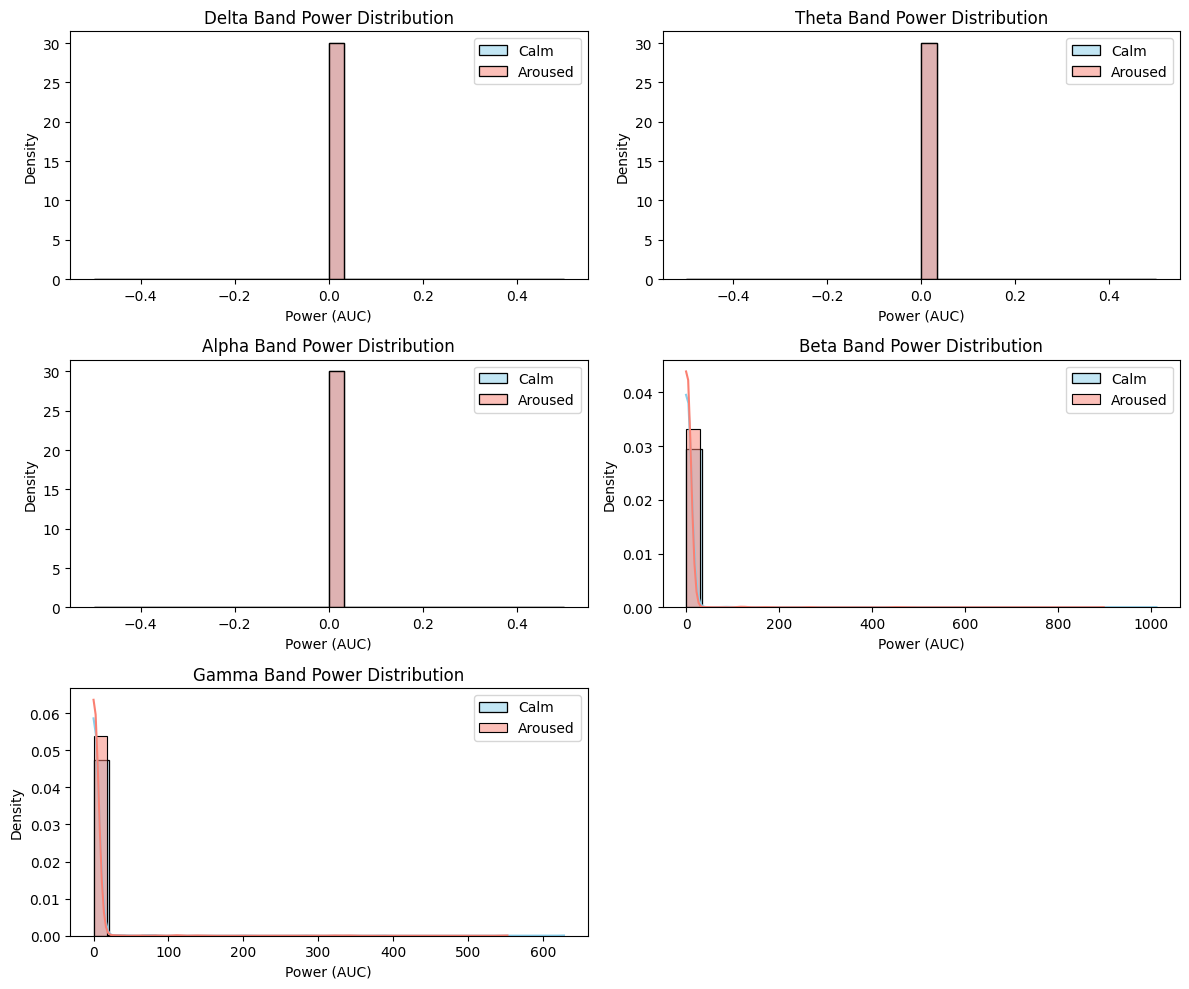

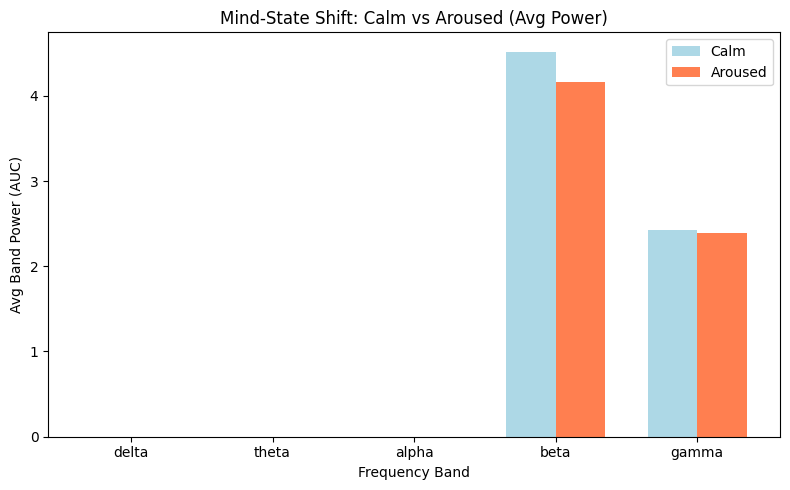

In [ ]:
import os, zipfile, numpy as np, pandas as pd, random
from scipy.signal import welch
from scipy.integrate import trapezoid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# STEP 1: UNZIP
zip_path = "/content/epicranialEEG_10rats.zip"
data_path = "/content/epicranialEEG_10rats"
if not os.path.exists(data_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_path)
    except zipfile.BadZipFile:
        print("The uploaded file is not a valid ZIP.")

# STEP 2: LOAD .eph FILES
def load_eph(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    n_channels, n_samples, fs = map(int, lines[0].strip().split('\t'))
    data = np.fromstring(' '.join(lines[1:]), sep=' ')
    return data.reshape(n_channels, n_samples), fs

# STEP 3: BAND POWER
def band_power(eeg, fs):
    bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30,100)}
    features = []
    for ch in eeg:
        f, Pxx = welch(ch, fs=fs, nperseg=min(len(ch), 256))
        for (low, high) in bands.values():
            mask = (f >= low) & (f <= high)
            features.append(trapezoid(Pxx[mask], f[mask]))
    return features

# STEP 4: BUILD DATASET
jitter = random.randint(0, 30)
samples = []
segment_len = 200  # longer segment length for better low-frequency expression
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".eph") and "Epoch" in file:
            path = os.path.join(root, file)
            eeg, fs = load_eph(path)
            rat = os.path.basename(os.path.dirname(os.path.dirname(path)))
            stim = os.path.basename(os.path.dirname(path))

            calm_start, calm_end = jitter, jitter + segment_len
            aroused_start, aroused_end = jitter + 40, jitter + 240  # adjusted for better spread

            if calm_end <= eeg.shape[1] and aroused_end <= eeg.shape[1]:
                calm = eeg[:, calm_start:calm_end]
                aroused = eeg[:, aroused_start:aroused_end]
                samples.append(band_power(calm, fs) + ["Calm", rat, stim])
                samples.append(band_power(aroused, fs) + ["Aroused", rat, stim])

columns = [f"{b}_ch{i+1}" for i in range(15) for b in ['delta','theta','alpha','beta','gamma']] + ['Label', 'Rat', 'Stim']
df = pd.DataFrame(samples, columns=columns)
print("\nDataset shape:", df.shape)

# STEP 5: SPLIT INTO TRAIN, TEST, VALIDATION
rats = df['Rat'].unique()
train_rats, temp_rats = train_test_split(rats, test_size=0.3, random_state=42)
val_rats, test_rats = train_test_split(temp_rats, test_size=2/3, random_state=42)

train_data = df[df['Rat'].isin(train_rats)]
val_data = df[df['Rat'].isin(val_rats)]
test_data = df[df['Rat'].isin(test_rats)]

X_train, y_train = train_data.drop(['Label', 'Rat', 'Stim'], axis=1), train_data['Label']
X_val, y_val = val_data.drop(['Label', 'Rat', 'Stim'], axis=1), val_data['Label']
X_test, y_test = test_data.drop(['Label', 'Rat', 'Stim'], axis=1), test_data['Label']

# STEP 6: Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train.values, y_train)

# Overfitting Check: Compare Train, Validation, and Test Accuracies
train_acc = accuracy_score(y_train, clf.predict(X_train.values))
val_acc = accuracy_score(y_val, clf.predict(X_val.values))
test_acc = accuracy_score(y_test, clf.predict(X_test.values))

print(f"\nTrain Accuracy:      {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy:       {test_acc:.2f}")


# STEP 7: Validate and Test
val_acc = accuracy_score(y_val, clf.predict(X_val.values))
test_acc = accuracy_score(y_test, clf.predict(X_test.values))
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# STEP 8: Final training and test
X_final_train = np.concatenate([X_train.values, X_val.values], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)
clf.fit(X_final_train, y_final_train)
y_final_test_pred = clf.predict(X_test.values)
final_test_acc = accuracy_score(y_test, y_final_test_pred)
print(f"Final Test Accuracy (after using validation data): {final_test_acc:.2f}")

# STEP 9: Save model
import joblib
joblib.dump(clf, "/content/eeg_brainstate_model.pkl")

# STEP 10: Confusion Matrix
cm = confusion_matrix(y_test, y_final_test_pred, labels=["Calm", "Aroused"])
ConfusionMatrixDisplay(cm, display_labels=["Calm", "Aroused"]).plot(cmap='Purples')
plt.title("Brain State Classification - Confusion Matrix")
plt.savefig("/content/confusion_matrix.png")
plt.show()

# STEP 11: PSD Plot for One Epoch
example_path = path  # reuse last loaded path
eeg, fs = load_eph(example_path)
plt.figure(figsize=(10, 6))
for i in range(min(5, eeg.shape[0])):  # plot first 5 channels
    f, Pxx = welch(eeg[i], fs=fs, nperseg=256)
    plt.semilogy(f, Pxx, label=f"Ch {i+1}")
plt.xlim(0, 100)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("EEG Power Spectral Density (Example Epoch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/psd_plot.png")
plt.show()

# STEP 12: Band Power Trends (Calm vs Aroused)
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_avg = {b: df[[col for col in df.columns if col.startswith(b)]].mean(axis=1) for b in bands}
band_df = pd.DataFrame(band_avg)
band_df['Label'] = df['Label']

plt.figure(figsize=(12, 10))
for i, band in enumerate(bands, 1):
    plt.subplot(3, 2, i)
    sns.histplot(band_df[band_df['Label'] == 'Calm'][band], color='skyblue', label='Calm', kde=True, stat='density', bins=30)
    sns.histplot(band_df[band_df['Label'] == 'Aroused'][band], color='salmon', label='Aroused', kde=True, stat='density', bins=30)
    plt.title(f"{band.capitalize()} Band Power Distribution")
    plt.xlabel("Power (AUC)")
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.savefig("/content/band_distributions.png")
plt.show()

# STEP 13: Mind-State Shift Visualization (Average Power Change)
avg_power_calm = band_df[band_df['Label'] == 'Calm'][bands].mean()
avg_power_aroused = band_df[band_df['Label'] == 'Aroused'][bands].mean()

plt.figure(figsize=(8, 5))
bar_width = 0.35
index = np.arange(len(bands))
plt.bar(index, avg_power_calm, bar_width, label='Calm', color='lightblue')
plt.bar(index + bar_width, avg_power_aroused, bar_width, label='Aroused', color='coral')
plt.xlabel("Frequency Band")
plt.ylabel("Avg Band Power (AUC)")
plt.title("Mind-State Shift: Calm vs Aroused (Avg Power)")
plt.xticks(index + bar_width / 2, bands)
plt.legend()
plt.tight_layout()
plt.savefig("/content/mindstate_shift.png")
plt.show()